French Road Accidents
==============
## __Pre-processing central pipeline__

**Authors**:
> - Pablo Galán de Anta
> - Jennifer Pohlsen
> - Ilinca Suciu

**Project supervisor**: Lucas Varela - DataScientest

**Date**: 2023-12-08

> This pipeline is the result of the combination of the code chunks in the central_pipeline.ipynb. The resulting files are the final __`merge_cleaned.csv`__ file, the data subset for years 2019-2022 named __`accidents_2019-2022.csv`__ and the individual .csv pre-processed files for each year from 2005 till 2022 called __`accidents_20XX.csv`__. All these files are the last one to work with in order to create the ML models, time series and get the final results of the project.

## __Opening .csv files and merging__

In [1]:
# Importing the required modules
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Path to the CSV file in your Google Drive
file_path = "/home/pablo/Descargas/project/"

# Read the CSV files into DataFrames
features = pd.read_csv(file_path + 'caracteristiques_merge.csv', encoding='latin')
users    = pd.read_csv(file_path + 'users_merge.csv', sep=',')
vehicles = pd.read_csv(file_path + 'vehicles_merge.csv')
lieux    = pd.read_csv(file_path + 'lieux_merge.csv')

# Merging the 4 CSVs into a master csv using pd.concat
merge1 = users.merge(vehicles, left_on=['Num_Acc', 'num_veh'], right_on=['Num_Acc', 'num_veh'], how='outer')
print('lenght users:',len(users))
print('lenght vehicles:',len(vehicles))
print('lenght lieux:',len(lieux))
print('lenght features:',len(features))
print('lenght users + vehicles:',len(merge1))

del vehicles; del users

merge2 = merge1.merge(lieux, left_on=['Num_Acc'], right_on=['Num_Acc'], how='outer')
del merge1; del lieux
print('lenght users + vehicles + lieux:',len(merge2))

merge = merge2.merge(features, left_on=['Num_Acc'], right_on=['Num_Acc'], how='outer')
del merge2; del features
print('lenght users + vehicles + lieux + features:',len(merge))

/tmp/ipykernel_6785/2513303837.py:10: DtypeWarning: Columns (4,10,12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  features = pd.read_csv(file_path + 'caracteristiques_merge.csv', encoding='latin')
/tmp/ipykernel_6785/2513303837.py:11: DtypeWarning: Columns (8,12,16) have mixed types. Specify dtype option on import or set low_memory=False.
  users    = pd.read_csv(file_path + 'users_merge.csv', sep=',')
/tmp/ipykernel_6785/2513303837.py:12: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  vehicles = pd.read_csv(file_path + 'vehicles_merge.csv')
/tmp/ipykernel_6785/2513303837.py:13: DtypeWarning: Columns (3,7,8,9,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  lieux    = pd.read_csv(file_path + 'lieux_merge.csv')


lenght users: 2636377
lenght vehicles: 1914902
lenght lieux: 1176873
lenght features: 1176873
lenght users + vehicles: 2665528
lenght users + vehicles + lieux: 2665528
lenght users + vehicles + lieux + features: 2665528


In [26]:
def split_and_save(set, name, num_parts = 4):
    # Splitting the dataset set into n-parts
    split_indices = [i * len(set) // num_parts for i in range(1, num_parts)]
    tt_set_parts = np.split(set, split_indices)
    
    # Saving each part into a separate file
    for i, part in enumerate(tt_set_parts):
        part.to_csv(f'../data/merge_data/{name}_parts_{i + 1}.csv', index=False)

# Saving the merge file into 10 different files for size quota
split_and_save(merge, 'merge', num_parts = 20)

C:\Users\jenni\anaconda3\envs\environment_version\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


## __Data pre-processing__

- ### (a) Changing names, re-assigning -1 values, and converting into a single data type.

In [2]:
# First we purge the column 'Unnamed: 0'
#merge.drop(columns='Unnamed: 0', axis=1, inplace=True)

# Also substitute the Severity to be sortened
severity_mapping = {
    1: 0,
    2: 3,
    3: 2,
    4: 1
}

merge['severity'] = merge['severity'].replace(severity_mapping)

# Deleting the -1 in severity
merge = merge[merge['severity'] != -1]

# Changing name of columns from French to English
merge.rename(columns={'an': 'year'}, inplace=True)
merge.rename(columns={'mois': 'month'}, inplace=True)
merge.rename(columns={'jour': 'day'}, inplace=True)

# Correct years to be in a consistent format
years = {5: 2005, 6: 2006, 7: 2007, 8:2008, 9:2009, 10:2010, 11:2011,
         12:2012, 13:2013, 14:2014, 15:2015, 16:2016, 17:2017, 18:2018}
merge['year'] = merge['year'].replace(to_replace=years)

# We create a new column with the age of the driver/passenger
merge['age'] = merge['year'] - merge['birth_year']

# Dropping down birth_year
merge.drop('birth_year', axis=1, inplace=True)

# We can delete columns id_vehicule, id_usager and num_veh as they are pointless for the analysis and
# the identificator of each accident can be extracted from Num_Acc
cols_to_delete = ['id_usager', 'id_vehicule_x', 'id_vehicule_y']
merge.drop(columns=cols_to_delete, axis=1, inplace=True)

# Deleting all columns with % of nulls above 90%
length = len(merge)
thres  = 0.9 # Threshold above which we delete columns
cols   = merge.columns.values # Getting the columns
idx    = merge.isna().sum().values/length < thres # Deleting conditions
merge_cleaned = merge[cols[idx]] # Purging all columns with % nulls above 90%

# actp is a special case as it's full of strings that we cannot turn into integers
merge_cleaned['actp'][merge_cleaned['actp'] == ' -1'] = '-1'
# Converting the NaNs into -1
merge_cleaned['actp'][merge_cleaned['actp'] == 'nan'] = '-1'

# Converting 'actp' into a str
merge_cleaned['actp'] = merge_cleaned['actp'].astype('str')

# Filling NaNs with -1 or 0 (not assigned)
cols_to_m1 = ['atm', 'col', 'senc', 'obs', 'obsm', 'choc', 'manv', 'motor', 'v1', 'prof', 'plan']
for ii in cols_to_m1:
    merge_cleaned[ii]   = merge_cleaned[ii].fillna(-1)

# For some columns we convert the NaNs to 0s
cols_to_0 = ['catv', 'lum', 'int']
for ii in cols_to_0:
    merge_cleaned[ii]   = merge_cleaned[ii].fillna(0)

cols = []
cols.extend(cols_to_m1)
cols.extend(cols_to_0)
# Converting into integers
for ii in cols:
    merge_cleaned[ii]   = merge_cleaned[ii].astype('int64')

# We need to turn 0.0, 1.0, 2.0, etc into 0, 1, 2, etc.
unique_values_mapping = {
    '0.0': '0',
    '3.0': '3',
    '1.0': '1',
    '5.0': '5',
    '2.0': '2',
    '9.0': '9',
    '6.0': '6',
    '4.0': '4'
}

merge_cleaned['actp'] = merge_cleaned['actp'].replace(unique_values_mapping)

# Just one single value with 'nbv' == #ERREUR, we delete it
merge_cleaned['nbv'] = merge_cleaned['nbv'][merge_cleaned['nbv'] != '#ERREUR']
# Now converting into float
merge_cleaned['nbv'] = merge_cleaned['nbv'].astype('float64')

# For 'pr' and 'pr1' we have a multiple values with (1) so we need to decide what to do with those
#merge_cleaned['pr'] = merge_cleaned['pr'].astype('float64')
#merge_cleaned['pr1'] = merge_cleaned['pr1'].astype('float64')

# Converting 'lartpc' into float. We first require to change the ',' with '.'
merge_cleaned['lartpc'] = merge_cleaned['lartpc'].astype('str')
merge_cleaned['lartpc'] = merge_cleaned['lartpc'].str.replace(',', '.')
merge_cleaned['lartpc'] = merge_cleaned['lartpc'].astype('float64')
# Same for 'larrout'
merge_cleaned['larrout'] = merge_cleaned['larrout'].astype('str')
merge_cleaned['larrout'] = merge_cleaned['larrout'].str.replace(',', '.')
merge_cleaned['larrout'] = merge_cleaned['larrout'].astype('float64')
# And for 'lat
merge_cleaned['lat'] = merge_cleaned['lat'].astype('str')
merge_cleaned['lat'] = merge_cleaned['lat'].str.replace(',', '.')
merge_cleaned['lat'] = merge_cleaned['lat'].astype('float64')
# And 'long
merge_cleaned['long'] = merge_cleaned['long'].astype('str')
merge_cleaned['long'] = merge_cleaned['long'].str.replace(',', '.').replace('-', np.nan)
merge_cleaned['long'] = merge_cleaned['long'].astype('float64')

# We want to turn 'hrmn' in a unified format 'hh:mm', but some values are in the format hhmm
merge_cleaned['hrmn'] = merge_cleaned['hrmn'].astype('str')
merge_cleaned['hrmn'] = merge_cleaned['hrmn'].apply(lambda x: x.zfill(4) if isinstance(x, str) and len(x) == 4 else x)
merge_cleaned['hrmn'] = pd.to_datetime(merge_cleaned['hrmn'], format='%H%M', errors='coerce').dt.strftime('%H:%M')

# The remaining columns 'com', 'adr' y 'sep' contain mixed values. WE just transform them into str
merge_cleaned['com'] = merge_cleaned['com'].astype('str')
merge_cleaned['adr'] = merge_cleaned['adr'].astype('str')
merge_cleaned['dep'] = merge_cleaned['dep'].astype('str')

/tmp/ipykernel_6785/1471758325.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_cleaned['actp'][merge_cleaned['actp'] == ' -1'] = '-1'
/tmp/ipykernel_6785/1471758325.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_cleaned['actp'][merge_cleaned['actp'] == 'nan'] = '-1'
/tmp/ipykernel_6785/1471758325.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_cl

- ### (b) Pre-processing of security equipment variables `secu1`, `secu2` and `secu3`.

In [3]:
# 1. Replace int categories with str

# Replace numeric values with corresponding string values - necessary for dummification
unique_values_mapping = {
    0 : '0',
    1: '1',
    2: '2',
    3: '3',
    4: '4',
    5: '5',
    6: '6',
    7: '7',
    8: '8',
    9: '9',
    -1: '-1',
    np.nan : '-1'
}

# NOTE: Instead of working on a merged dataset, this could be done directly on the users table
merge_cleaned[['secu1', 'secu2', 'secu3']] = merge_cleaned[['secu1', 'secu2', 'secu3']].replace(unique_values_mapping)

# 2. Dealing with universally not worn or absent security equipment entries

# Although not explained in the description file, it is expected that values
# for secu1, secu2 and secu3 variables are filled in this order

# Check assumption that if security equipment is recorded as absent in secu1,
# it will also be mostly absent or missing in secu2 and secu3
#print('\n ', merge_cleaned[merge_cleaned['secu1'] == '0'][['secu1', 'secu2', 'secu3']].value_counts(), '\n')

# For the entirely absent security equipment, assign a distinct categorical value in secu1
merge_cleaned.loc[(merge_cleaned['secu1'] == '0') # protection equipment: absent in secu1
             & (merge_cleaned['secu2'].isin(['0', '-1'])) # absent or not not recorded in secu2 and secu3
             & (merge_cleaned['secu3'].isin(['0', '-1'])), 'secu1'] = '-2' # assign new category (= absent allthroughout)

# Check how having the security equipment not recorded in secu1 correlates with the other 2 security variables
#print('\n ',merge_cleaned[merge_cleaned['secu1'] == '-1'][['secu1', 'secu2', 'secu3']].value_counts(), '\n')

# For the non-recorded security equipment in secu1, assign a distinct categorical value in secu1
# if in the other 2 variables it is also either absent or not recorded
merge_cleaned.loc[(merge_cleaned['secu1'] == '-1') # protection equipment: not recorded in secu1
             & (merge_cleaned['secu2'].isin(['0', '-1'])) # absent or not not recorded in secu2 and secu3
             & (merge_cleaned['secu3'].isin(['0', '-1'])), 'secu1'] = '-3' # assign new category (= NA allthroughout)

# 3. Dummification of security variables and creating new collumns which gather all 'ones' of the same category
'''
new_secu = pd.get_dummies(merge_cleaned[['Num_Acc', 'secu1', 'secu2', 'secu3']])
new_secu = new_secu.drop(['secu1_-1', 'secu1_0', 'secu2_0', 'secu3_0', 'secu2_-1', 'secu3_-1'], axis =1) # discard unnecessary dummies
for suffix in ['1', '2', '3', '4', '5', '6', '7', '8', '9']:
        var_name1 = 'secu1_' + suffix
        var_name2 = 'secu2_' + suffix
        var_name3 = 'secu3_' + suffix
       # print(var_name1, '; ', var_name2, '; ', var_name3)
        new_secu['secu_' + suffix] = new_secu[var_name1] + new_secu[var_name2] + new_secu[var_name3] # create new unique variable for the category
        new_secu = new_secu.drop([var_name1, var_name2, var_name3], axis = 1) # drop old variables of that category

# Check new security variables
#new_secu.head()


# 4. Optional rename columns ... according to the type of security they're coding for
col_mapping = {
    'secu1_-2' : 'secu_absent',
    'secu1_-3': 'secu_NA',
    'secu_1': 'secu_belt',
    'secu_2': 'secu_helmet',
    'secu_3': 'secu_child-restraint',
    'secu_4': 'secu_reflective-vest',
    'secu_5': 'secu_airbag',
    'secu_6': 'secu_gants',
    'secu_7': 'secu_airbag-gants',
    'secu_8': 'secu_undet',
    # secu_undet = undeterminable, probably in severe accidents;
    # in which case I suggest removing it (because it depend on accident severity, and not the other way around)
    'secu_9': 'secu_other'
}

new_secu = new_secu.rename(columns = col_mapping)


# 5. Replace values of '2' and '3' with '1'
new_secu.info()
new_secu = new_secu.replace({2.0: 1,
                             3.0 : 1})

# Check that there are no additional otliers present (i.e. values consist exclusively of '0' and '1')
new_secu.describe()

# NOTE: the new_secu dataframe needs to be now merged with the dataframe it originated from, where secu_1, secu_2 and secu_3 variables will be dropped.
merge_cleaned = merge_cleaned.drop(['secu1', 'secu2', 'secu3'], axis = 1)
# merge_02['Num_Acc'] = merge_02['Num_Acc'].astype(object)
merge_cleaned = merge_cleaned.merge(new_secu, left_on=['Num_Acc'], right_on=['Num_Acc'], how='outer')
del new_secu


# 6. Check correlations between the newly constructed security variables

#secu_and_sev = list(merge_cleaned.loc[:,'secu_absent':'secu_other'].columns)
#secu_and_sev.append('severity')
#print(secu_and_sev)

#plt.figure(figsize = (10,8))
#sns.heatmap(merge_cleaned.loc[merge_cleaned['year'].isin([2019, 2020, 2021, 2022]), 
#                              merge_cleaned.columns.isin(secu_and_sev)].corr(), 
#            cmap = 'bwr', center = 0, annot = True, fmt = ".2f");
#del secu_and_sev
'''

/tmp/ipykernel_6785/3901971910.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_cleaned[['secu1', 'secu2', 'secu3']] = merge_cleaned[['secu1', 'secu2', 'secu3']].replace(unique_values_mapping)


'\nnew_secu = pd.get_dummies(merge_cleaned[[\'Num_Acc\', \'secu1\', \'secu2\', \'secu3\']])\nnew_secu = new_secu.drop([\'secu1_-1\', \'secu1_0\', \'secu2_0\', \'secu3_0\', \'secu2_-1\', \'secu3_-1\'], axis =1) # discard unnecessary dummies\nfor suffix in [\'1\', \'2\', \'3\', \'4\', \'5\', \'6\', \'7\', \'8\', \'9\']:\n        var_name1 = \'secu1_\' + suffix\n        var_name2 = \'secu2_\' + suffix\n        var_name3 = \'secu3_\' + suffix\n       # print(var_name1, \'; \', var_name2, \'; \', var_name3)\n        new_secu[\'secu_\' + suffix] = new_secu[var_name1] + new_secu[var_name2] + new_secu[var_name3] # create new unique variable for the category\n        new_secu = new_secu.drop([var_name1, var_name2, var_name3], axis = 1) # drop old variables of that category\n\n# Check new security variables\n#new_secu.head()\n\n\n# 4. Optional rename columns ... according to the type of security they\'re coding for\ncol_mapping = {\n    \'secu1_-2\' : \'secu_absent\',\n    \'secu1_-3\': \'secu_N

- ### (c) Deal with outliers in `lat` and `long`.

In [4]:
# Lat, Long (0,0) is an obvious missing value, as it is in the ocean. Replace those with nan
merge_cleaned.loc[(merge_cleaned['lat']==0.0) & (merge_cleaned['long']==0.0), ['lat', 'long']] = np.nan

# From comments on the government website we know that some values of lat are missing the . after the first two characters,
# and some values of long are missing a leading 0 and . after the first two characters.

# Since the dataset also includes entries from the overseas departments, we can't be sure about whether the decimal should be after the first or second character.
# So we will only apply our correction to entries in mainland France, then we know the reasonable ranges.

# Latitude correction
# Valid range of latitude is -90 to 90 degrees - assume any value outside this range is missing decimal point
def fix_lat(x):
    if x < -90 or x > 90:
        xstring = str(x)
        xstring = xstring[:2] + '.' + xstring[2:]
        # because the column was already casted to float, now they all have a .0 at the end, remove it
        if xstring[-2:] == '.0':
            xstring = xstring[:-2]
        x = float(xstring)
    return x

merge_cleaned.loc[merge_cleaned['gps']=='M', 'lat'] = merge_cleaned['lat'].apply(fix_lat)
# Mainland france lies between 40 and approx. 51 degrees latitude. Filter anything less than 35 out.
merge_cleaned.loc[(merge_cleaned['gps']=='M') & (merge_cleaned['lat']<35), 'lat'] = np.nan

# Longitude correction
# Valid range of longitude is -180 to 180 degrees - assume any value outside this range is missing decimal point
def fix_long(x):
    if x < -180 or x > 180:
        xstring = str(x)
        xstring = xstring[:1] + '.' + xstring[1:]
        # because the column was already casted to float, now they all have a .0 at the end, remove it
        if xstring[-2:] == '.0':
            xstring = xstring[:-2]
        x = float(xstring)
    return x

merge_cleaned.loc[merge_cleaned['gps']=='M', 'long'] = merge_cleaned['long'].apply(fix_long)
# Mainland france lies between -5 and approx. 8.3 degrees longitude. Filter anything outside of (-5, 8.5) out.
merge_cleaned.loc[(merge_cleaned['gps']=='M') & ((merge_cleaned['long']<-5) | (merge_cleaned['long']>8.5)), 'long'] = np.nan

# It would of course be possible to do the same correction for each overseas territory as well. But as the number of remaining unreasonable values is very small compared to the total
# number of entries, these will not have much affect on our planned analysis and is outside the scope of this project. Set these remaining values to nan.
merge_cleaned.loc[(merge_cleaned['lat']>90.0) | (merge_cleaned['lat']<-90.0), 'lat'] = np.nan
merge_cleaned.loc[(merge_cleaned['long']>180.0) | (merge_cleaned['long']<-180.0), 'long'] = np.nan

# Just filter lat and long to only mainland France since we are not correcting outliers/wrong values for overseas territories
merge_cleaned.loc[((merge_cleaned['lat'])<0), 'long'] = np.nan # filter out all territories in southern hemisphere
merge_cleaned.loc[((merge_cleaned['lat'])<0), 'lat'] = np.nan # filter out all territories in southern hemisphere
merge_cleaned.loc[((merge_cleaned['long']<-5) | (merge_cleaned['long']>8.5)), 'lat'] = np.nan # filter out remaining territories in northern hemisphere (by Canada)
merge_cleaned.loc[((merge_cleaned['long']<-5) | (merge_cleaned['long']>8.5)), 'long'] = np.nan # filter out remaining territories in northern hemisphere (by Canada)

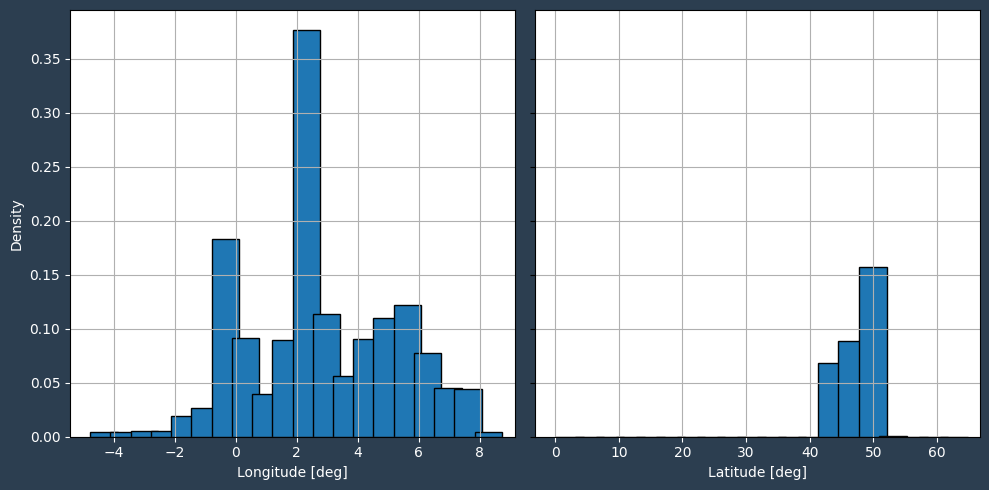

In [9]:
fig, ax = plt.subplots(1,2,figsize=(10,5), sharey=True)
ax = ax.ravel()

merge_cleaned['long'].hist(bins=20, ax=ax[0], density=True, edgecolor='black', width=0.9)
merge_cleaned['lat'].hist(bins=20, ax=ax[1], density=True, edgecolor='black', width=4.5)

# Severity labels
severity_labels = ['Unharmed', 'Minor injury', 'Hospitalised injury', 'Killed']

ax[0].set_ylabel('Density', color='white')
ax[0].set_xlabel('Longitude [deg]', color='white'); ax[1].set_xlabel('Latitude [deg]', color='white')

# Set a dark gray background color for the area with labels and title
fig.patch.set_facecolor('#2c3e50')

plt.tight_layout()

# Set the text color for y-axis ticks
ax[0].tick_params(axis='y', colors='white')
ax[0].tick_params(axis='x', colors='white'); ax[1].tick_params(axis='x', colors='white')

plt.savefig('../plots/long_lat.png',bbox_inches='tight', dpi = 150)

- ### (d) Excluding outliers and aberrant values in `age`.

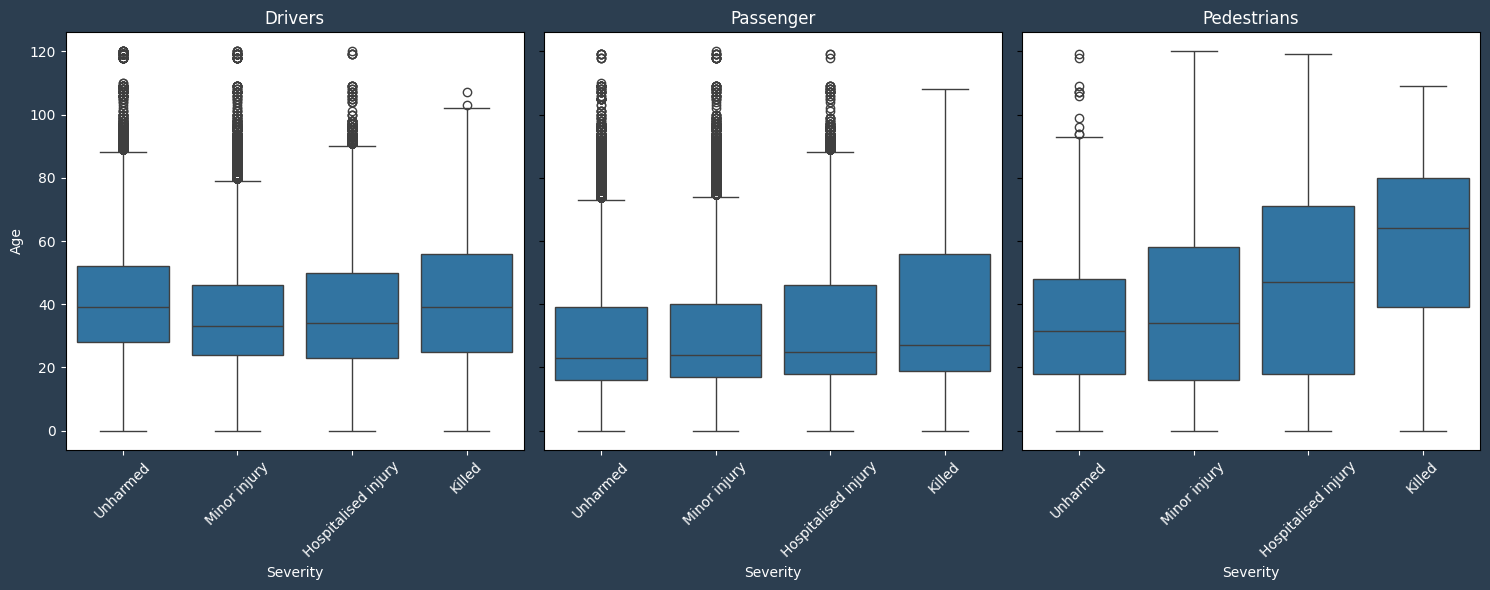

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6), sharey=True)
ax = ax.ravel()

sns.boxplot(x="severity", y="age", data=merge_cleaned[merge_cleaned['catu'] == 1], ax=ax[0])
sns.boxplot(x="severity", y="age", data=merge_cleaned[merge_cleaned['catu'] == 2], ax=ax[1])
sns.boxplot(x="severity", y="age", data=merge_cleaned[merge_cleaned['catu'] == 3], ax=ax[2])

# Severity labels
severity_labels = ['Unharmed', 'Minor injury', 'Hospitalised injury', 'Killed']

ax[0].set_ylabel('Age', color='white')
ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[0].set_xlabel('Severity', color='white')
ax[1].set_xlabel('Severity', color='white')
ax[2].set_xlabel('Severity', color='white')

tick_positions = list(range(len(severity_labels)))

for i in range(3):
    ax[i].set_xticks(tick_positions)
    ax[i].set_xticklabels(severity_labels, rotation=45)

ax[0].set_title('Drivers', color='white')
ax[1].set_title('Passenger', color='white')
ax[2].set_title('Pedestrians', color='white')

# Set a dark gray background color for the area with labels and title
fig.patch.set_facecolor('#2c3e50')

# Set the text color for y-axis ticks
ax[0].tick_params(axis='y', colors='white')
ax[0].tick_params(axis='x', colors='white'); ax[1].tick_params(axis='x', colors='white'); ax[2].tick_params(axis='x', colors='white')

plt.tight_layout()
plt.savefig('../plots/boxplot_age.png',bbox_inches='tight', dpi = 150)

In [14]:
# Create a new column 'filter' and assign 0 as default value
merge_cleaned['filter'] = 0

# Apply conditions and assign appropriate labels to 'filter' column
merge_cleaned.loc[(merge_cleaned['catu'] == 1) & (merge_cleaned['age'].between(18, 100)), 'filter'] = 1
merge_cleaned.loc[(merge_cleaned['catu'] == 2) & (merge_cleaned['age'] <= 100), 'filter'] = 2
merge_cleaned.loc[(merge_cleaned['catu'] == 3) & (merge_cleaned['age'] <= 100), 'filter'] = 3

# Contrain the dataset to our filtered values
merge_cleaned = merge_cleaned[merge_cleaned['filter'] > 0]

# Deleting the column 'filter'
merge_cleaned.drop('filter', axis=1, inplace=True)

# Calculate Q1, Q3, and IQR for each severity category
merge_cleaned['Q1'] = merge_cleaned.groupby('severity')['age'].transform(lambda x: x.quantile(0.25))
merge_cleaned['Q3'] = merge_cleaned.groupby('severity')['age'].transform(lambda x: x.quantile(0.75))
merge_cleaned['IQR'] = merge_cleaned['Q3'] - merge_cleaned['Q1']

# Calculate lower and upper bounds for outliers removal
merge_cleaned['lower_bound'] = merge_cleaned['Q1'] - 1.5 * merge_cleaned['IQR']
merge_cleaned['upper_bound'] = merge_cleaned['Q3'] + 1.5 * merge_cleaned['IQR']

# Remove outliers based on each 'severity' category
merge_cleaned = merge_cleaned[(merge_cleaned['severity'].isin([0, 1, 2, 3])) &
                              (merge_cleaned['age'] >= merge_cleaned['lower_bound']) &
                              (merge_cleaned['age'] <= merge_cleaned['upper_bound'])]

# Drop temporary columns used for calculations
merge_cleaned.drop(columns=['Q1', 'Q3', 'IQR', 'lower_bound', 'upper_bound'], inplace=True)

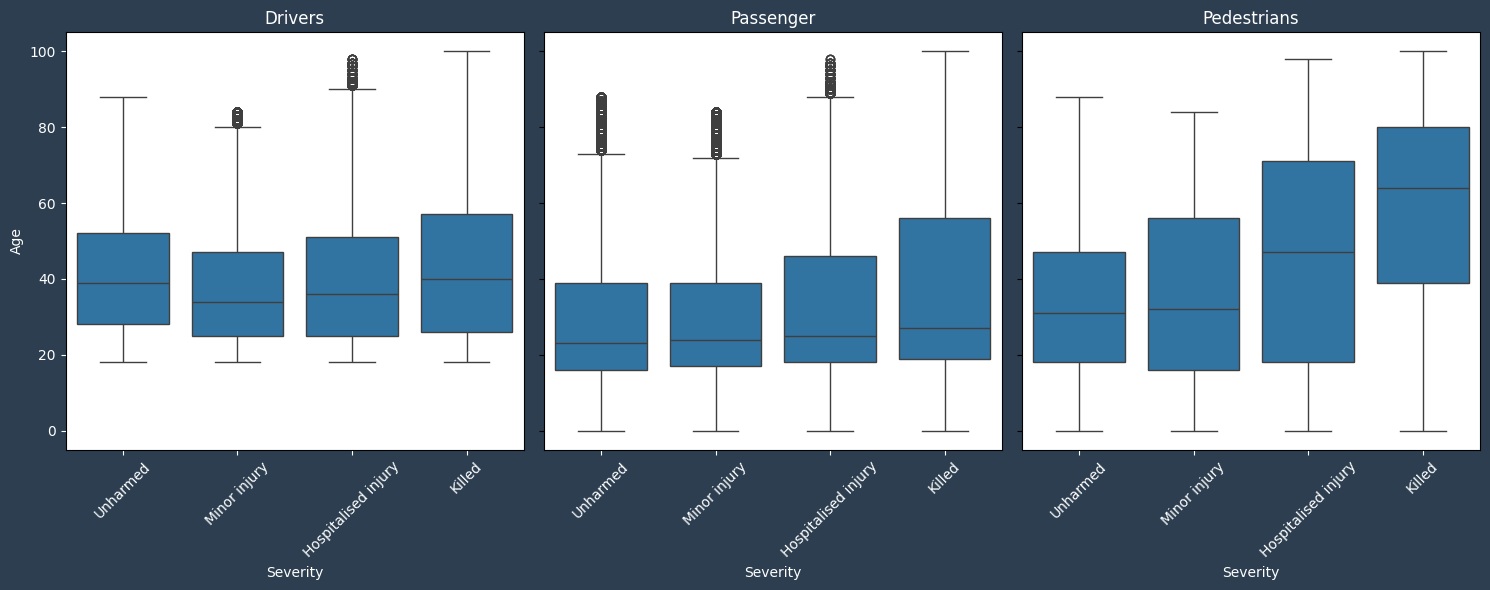

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6), sharey=True)
ax = ax.ravel()

sns.boxplot(x="severity", y="age", data=merge_cleaned[merge_cleaned['catu'] == 1], ax=ax[0])
sns.boxplot(x="severity", y="age", data=merge_cleaned[merge_cleaned['catu'] == 2], ax=ax[1])
sns.boxplot(x="severity", y="age", data=merge_cleaned[merge_cleaned['catu'] == 3], ax=ax[2])

# Severity labels
severity_labels = ['Unharmed', 'Minor injury', 'Hospitalised injury', 'Killed']

ax[0].set_ylabel('Age', color='white')
ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[0].set_xlabel('Severity', color='white')
ax[1].set_xlabel('Severity', color='white')
ax[2].set_xlabel('Severity', color='white')

tick_positions = list(range(len(severity_labels)))

for i in range(3):
    ax[i].set_xticks(tick_positions)
    ax[i].set_xticklabels(severity_labels, rotation=45)

ax[0].set_title('Drivers', color='white')
ax[1].set_title('Passenger', color='white')
ax[2].set_title('Pedestrians', color='white')

# Set a dark gray background color for the area with labels and title
fig.patch.set_facecolor('#2c3e50')

# Set the text color for y-axis ticks
ax[0].tick_params(axis='y', colors='white')
ax[0].tick_params(axis='x', colors='white'); ax[1].tick_params(axis='x', colors='white'); ax[2].tick_params(axis='x', colors='white')

plt.tight_layout()
plt.savefig('../plots/boxplot_age_cleaned.png',bbox_inches='tight', dpi = 150)

## __Writing the final merged file and subsets for each year__

Final total file
> __ADVICE__: this `merge_cleaned.csv` file along with `accidents_subset_2019-2022.csv` file are too heavy to upload them to GitHub so you cannot commit changes any more if you add them!

In [ ]:
#merge_cleaned.to_csv('merge_cleaned.csv', sep=',')

Subsets for each year

In [21]:
years = merge_cleaned['year'].unique()
for ii in years:
    merge_cleaned[merge_cleaned['year'] == ii].to_csv('../data/accidents_'+str(int(ii))+'.csv')

Subset for period 2019-2022

In [ ]:
#merge_cleaned[merge_cleaned['year'] >= 2019].to_csv('../data/accidents_subset_2019-2022.csv')